# &#x1F4D1; &nbsp;  Image Generator of Digits
## Libraries

In [1]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #818286; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [2]:
import numpy as np 
import pandas as pd
import math
from scipy import misc
from collections import namedtuple

import cv2
from PIL import ImageFile, Image
from tqdm import tqdm
from glob import glob

from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tflearn

from tflearn.data_utils import build_hdf5_image_dataset

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [3]:
def get_batches(images, batch_size):
    current_index = 0
    while current_index + batch_size <= images.shape[0]:
        data_batch = images[current_index:current_index + batch_size]
        current_index += batch_size
        yield data_batch / 255 - 0.5 

def images_square_grid(images, mode):
    save_size = math.floor(np.sqrt(images.shape[0]))
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    images_in_square = np.reshape(images[:save_size*save_size],
                                  (save_size, save_size, 
                                   images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

## Datasets

In [4]:
df_train = pd.read_csv("kaggle_digits_train.csv")
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
digit_images = np.array(df_train[images])
digit_images = digit_images.astype('float32').reshape(-1, 28,28,1)
digit_images.shape

(42000, 28, 28, 1)

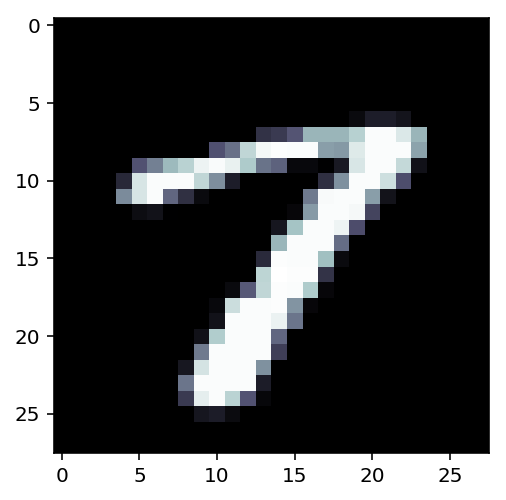

In [9]:
plt.imshow(np.squeeze(digit_images[3000]), cmap=cm.bone);

## NN Model

In [23]:
stddev = 0.01
alpha = 0.1
learning_rate = 0.00025
beta1 = 0.5 
z_dim = 128
batch_size = 32
epochs = 2

In [11]:
def nn_inputs(image_width, image_height, image_channels, z_dim):
    input_real = tf.placeholder(tf.float32, 
                                shape=[None, image_width, image_height, image_channels], # rank 4
                                name="Real_Input") 
    
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Z_Input") # rank 2    
    input_learning_rate = tf.placeholder(tf.float32, shape=[], name="Learning_Rate") # rank 0
    
    return input_real, input_z, input_learning_rate

In [12]:
def nn_discriminator(images, reuse=False, alpha=alpha):
    with tf.variable_scope('discriminator', reuse=reuse):
        # image shape [28,28,3]
        x = tf.layers.conv2d(images, 32, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x) 
        
        # input shape [14,14,32]       
        x = tf.layers.conv2d(x, 96, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)        
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [7,7,96]        
        x = tf.layers.conv2d(x, 128, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)       
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [4,4,128]       
        x = tf.reshape(x, (-1, 4*4*128))
        
        discriminator_logits = tf.layers.dense(x, 1)
        discriminator_outputs = tf.sigmoid(discriminator_logits)
        
    return discriminator_outputs, discriminator_logits

In [13]:
def nn_generator(z, out_channel_dim, is_train=True, alpha=alpha):
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.maximum(x * alpha, x)          
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # input shape [7,7,128]       
        x = tf.layers.conv2d_transpose(x, 96, 5, strides=2, 
                                       kernel_initializer=\
                                       tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)          
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [14,14,96]
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2,
                                       kernel_initializer=\
                                       tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)              
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [28,28,32]        
        generator_logits = \
        tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, 
                                   kernel_initializer=\
                                   tf.random_normal_initializer(stddev=stddev), 
                                   padding='same')

        # input shape [28,28,3]         
        generator_outputs = tf.tanh(generator_logits)
    
    return generator_outputs    

In [14]:
def nn_loss(input_real, input_z, out_channel_dim, alpha=alpha, index="leaky_relu"):    
    if index=="relu":
        img_generator = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = discriminator(input_real, reuse=False, alpha=alpha)
        generator_outputs, generator_logits = discriminator(img_generator, 
                                                            reuse=True, alpha=alpha)
    elif index=="leaky_relu":
        img_generator = nn_generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = nn_discriminator(input_real, alpha=alpha)
        generator_outputs, generator_logits = nn_discriminator(img_generator, 
                                                               reuse=True, alpha=alpha)        
    
    real_labels = tf.ones_like(real_outputs) * (1 - alpha)
    zeros_labels = tf.zeros_like(generator_outputs)
    ones_labels = tf.ones_like(generator_outputs)

    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                       labels=real_labels))
    zeros_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                        labels=zeros_labels))
    ones_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                       labels=ones_labels))

    return real_loss + zeros_loss, ones_loss

In [15]:
def nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1):

    trainable_variables = tf.trainable_variables()
    discriminator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('discriminator')]
    generator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops = \
    [u for u in update_ops if u.name.startswith('discriminator')]
    generator_update_ops = \
    [u for u in update_ops if u.name.startswith('generator')]

    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                                   beta1=beta1).\
        minimize(discriminator_loss, var_list=discriminator_trainable_variables)

    with tf.control_dependencies(generator_update_ops):
        generator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                               beta1=beta1).\
        minimize(generator_loss, var_list=generator_trainable_variables)
            
    return discriminator_training_operations, generator_training_operations

In [16]:
def train(images, epoch_count, batch_size, z_dim, learning_rate, beta1, 
          data_shape, data_image_mode, print_step, show_step):
    
    input_real, input_z, input_learning_rate = \
    nn_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    discriminator_loss, generator_loss = \
    nn_loss(input_real, input_z, data_shape[3], alpha=alpha, index="leaky_relu")
    
    discriminator_training_operations, generator_training_operations = \
    nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1)
    
    train_step = 0
    DTL, GTL = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(images, batch_size):
                train_step += 1
                batch_images *= 2.0                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_training_operations, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(generator_training_operations, 
                             feed_dict={input_z: batch_z})

                if train_step % print_step == 0:
                    discriminator_training_loss = \
                    discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    generator_training_loss= \
                    generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}| Step {}|".format(epoch_i + 1, epochs, train_step),
                          "Discriminator Loss:{:.5f}|".format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|".format(generator_training_loss),
                          "Discriminator Loss>Generator Loss: {}"\
                          .format(discriminator_training_loss>generator_training_loss))
                    
                    DTL.append(discriminator_training_loss) 
                    GTL.append(generator_training_loss) 
                    
                if train_step % show_step == 0:
                    cmap = None if data_image_mode == 'RGB' else 'gray'
                    z_dim = input_z.get_shape().as_list()[-1]
                    example_z = np.random.uniform(-1, 1, size=[25, z_dim])

                    samples = sess.run(nn_generator(input_z, data_shape[3], False),
                                       feed_dict={input_z: example_z})

                    images_grid = images_square_grid(samples, data_image_mode)
                    plt.figure(figsize=(5, 5))
                    plt.imshow(images_grid, cmap=cmap)
                    plt.show()
                            
    plt.figure(figsize=(18, 6))
    plt.plot(DTL, label = 'discriminator')
    plt.plot(GTL, label = 'generator')
    plt.legend()
    plt.title('Loss Function');

## Generate Images

Epoch 1/2| Step 100| Discriminator Loss:0.38394| Generator Loss:3.73422| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 200| Discriminator Loss:1.40437| Generator Loss:0.47306| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 300| Discriminator Loss:1.53368| Generator Loss:0.52828| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 400| Discriminator Loss:1.01585| Generator Loss:1.29975| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 500| Discriminator Loss:1.00561| Generator Loss:1.16793| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 600| Discriminator Loss:1.73392| Generator Loss:0.34705| Discriminator Loss>Generator Loss: True


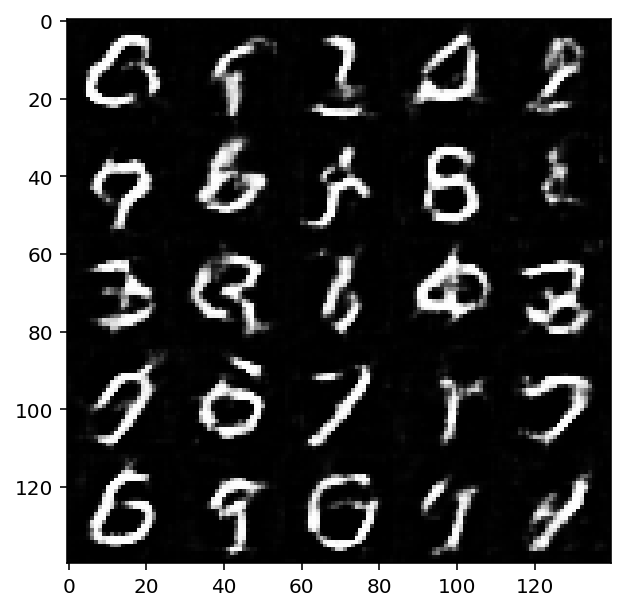

Epoch 1/2| Step 700| Discriminator Loss:0.96983| Generator Loss:1.10805| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 800| Discriminator Loss:1.26437| Generator Loss:0.72652| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 900| Discriminator Loss:1.32310| Generator Loss:0.64156| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1000| Discriminator Loss:1.00414| Generator Loss:1.08337| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 1100| Discriminator Loss:0.98328| Generator Loss:0.98233| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1200| Discriminator Loss:1.05625| Generator Loss:0.94466| Discriminator Loss>Generator Loss: True


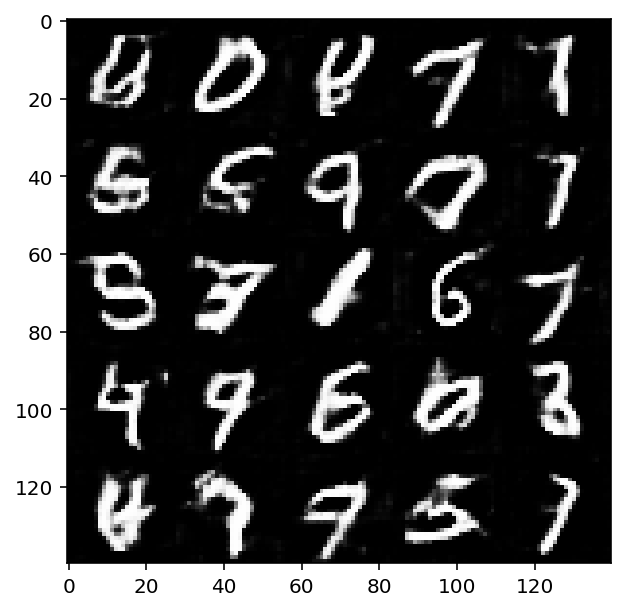

Epoch 1/2| Step 1300| Discriminator Loss:1.07181| Generator Loss:1.14296| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 1400| Discriminator Loss:0.95118| Generator Loss:1.16843| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 1500| Discriminator Loss:1.22192| Generator Loss:0.71517| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1600| Discriminator Loss:1.46665| Generator Loss:0.53041| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1700| Discriminator Loss:1.33533| Generator Loss:0.56873| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1800| Discriminator Loss:1.31337| Generator Loss:0.66507| Discriminator Loss>Generator Loss: True


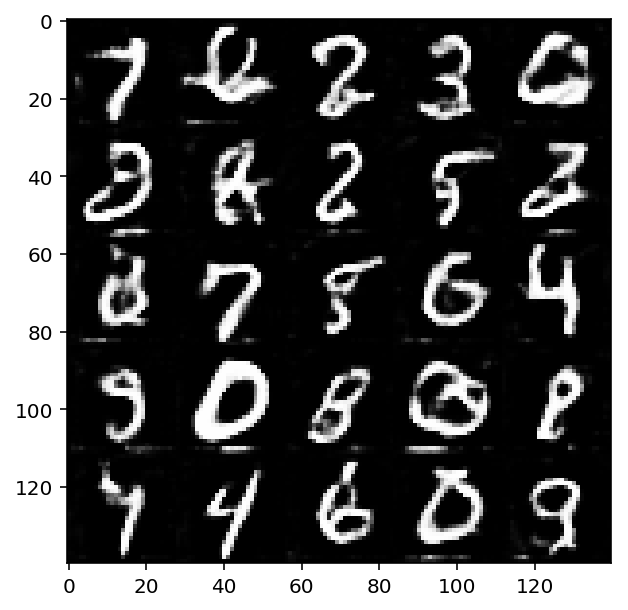

Epoch 2/2| Step 1900| Discriminator Loss:1.19518| Generator Loss:1.15905| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2000| Discriminator Loss:1.21053| Generator Loss:0.67634| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2100| Discriminator Loss:1.22163| Generator Loss:0.70871| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2200| Discriminator Loss:1.37539| Generator Loss:0.53858| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2300| Discriminator Loss:1.15832| Generator Loss:0.76972| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2400| Discriminator Loss:1.40754| Generator Loss:0.63138| Discriminator Loss>Generator Loss: True


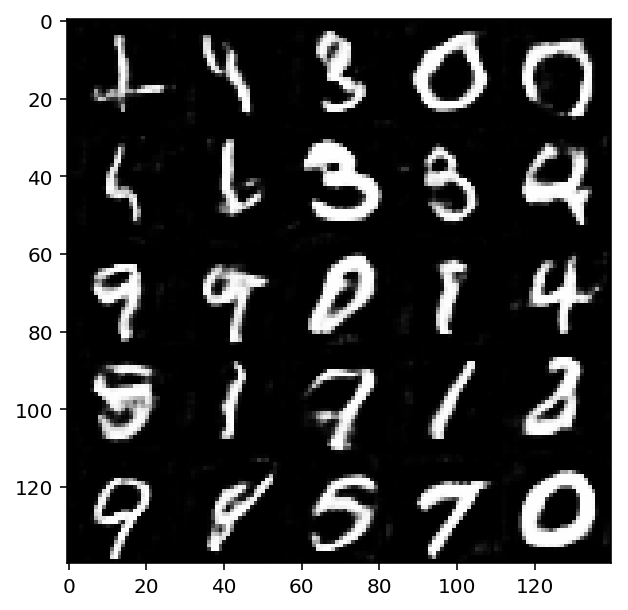

Epoch 2/2| Step 2500| Discriminator Loss:0.77169| Generator Loss:1.58712| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 2600| Discriminator Loss:1.31416| Generator Loss:0.60325| Discriminator Loss>Generator Loss: True


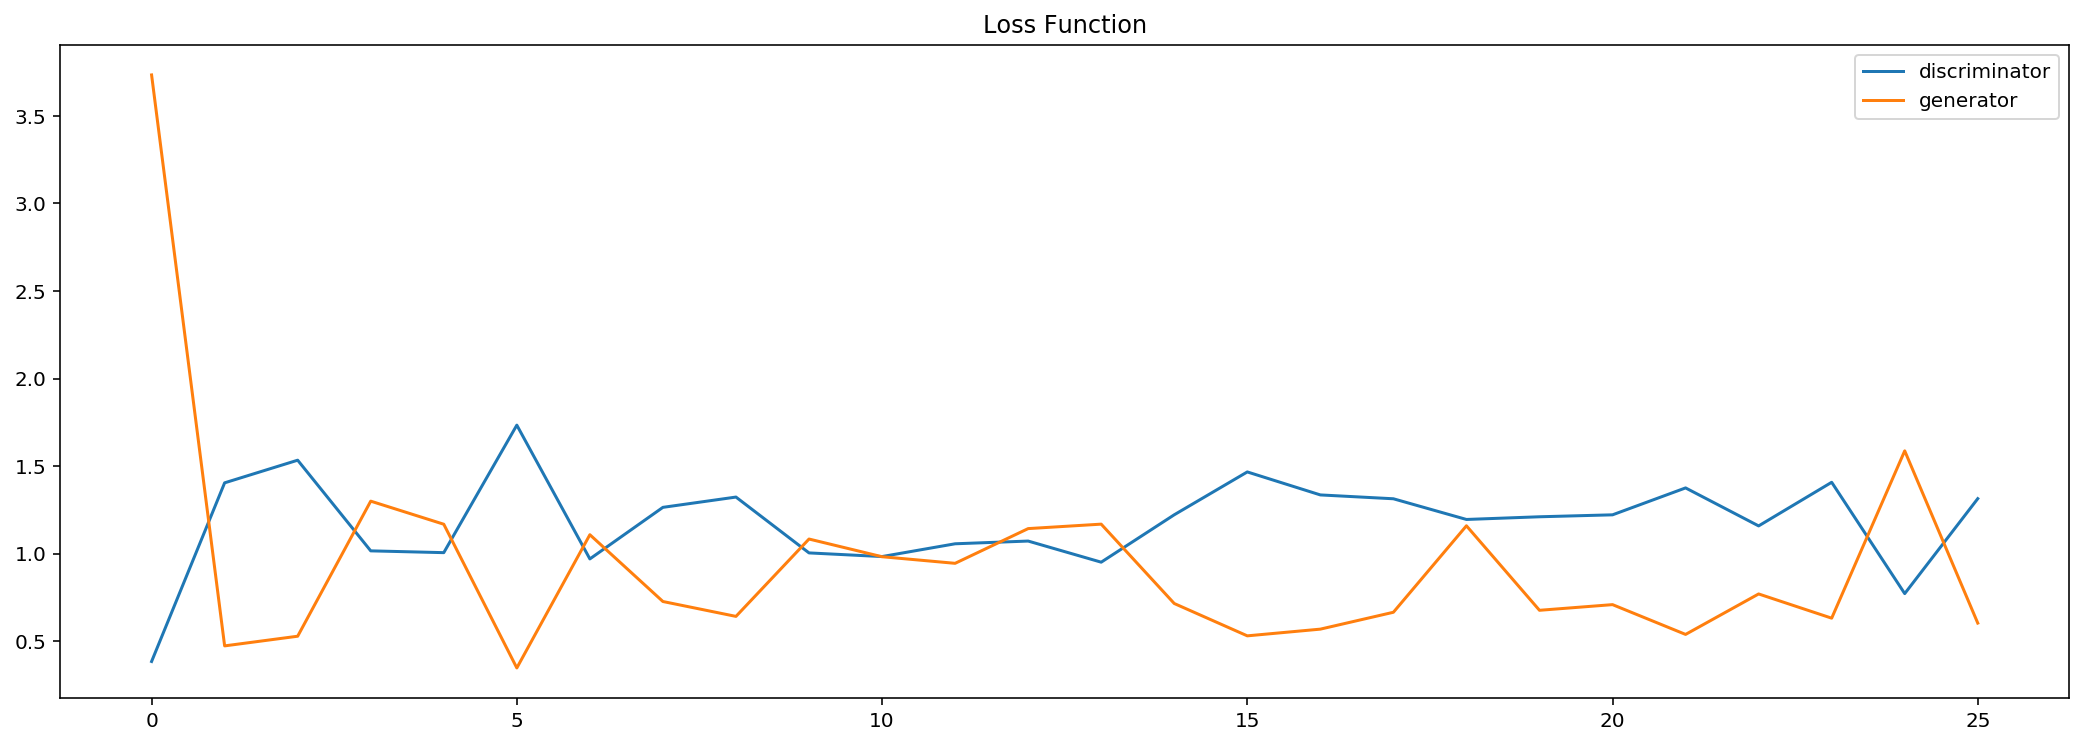

In [24]:
with tf.Graph().as_default():
    train(digit_images, epochs, batch_size, 
          z_dim, learning_rate, beta1, 
          digit_images.shape, "L", 100, 600)